In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numba import jit
from time import time
import random

In [2]:
def plotCommands(xlabel, ylabel, title, xscale = False, yscale = False, legend = False, printString = ""):
    #Function containing the usual commands when plotting with matplotlib.pyplot
    #If log-scaled x- and/or y-axis is needed, set xscale and/or yscale to True
    #If the figure has a label, set legend = True
    #If extra information is needed, use printString
    plt.xlabel(xlabel, size = 20)
    plt.ylabel(ylabel, size = 20)
    plt.title(title, size = 27)
    if xscale:
        plt.xscale('log')
    if yscale:
        plt.yscale('log')
    if legend:
        plt.legend()
    plt.grid()
    if printString:
        print(printString)
    plt.show()
    return None

In [3]:
plt.rcParams["figure.figsize"] = (15, 7) #Increase figure size

In [4]:
alpha = 0.005
beta = 0.01
gamma = 0.10

P = np.array([
    [1-beta, beta, 0],
    [0, 1-gamma, gamma],
    [alpha, 0, 1-alpha]
])

P_modified = np.array([
    [1 - beta, 1, 0],
    [0, 1-gamma, 1],
    [alpha, 0, 1]
])

As we're comparing the randomly selected number to the first number larger than it, and we only have two non-zero elements in each row, we set the second non-zero element to be 1. The transition probability remains the same, however we can do an efficient check to determine the next state.

# Problem 1c)

In [5]:
@jit(nopython = True)
def simulate_individual(P, X0 = 0, n = 7300):
    """
    Simulates an individual for n days.
    
    Arguments
    ---------------------------------------
    P: NxN square matrix
        Transition probability matrix
    X0: int
        Initial state (0, 1 or 2)
    n: int
        Number of days to be simulated
        
    Returns
    ---------------------------------------
    pi: 1x3 array (1x(number of states))
        Simulated long-run mean
    """
    
    state = np.zeros(n, dtype = np.intc)#The state (either 0, 1 or 2) for all times
    state[0] = int(X0)#Initial state
    
    
    random = np.random.random(n)
    for i in range(1, n):
        #Find the transition probabilities from state i-1
        #Then find the first element in array greater than random, index determines state i
        state[i] = np.where(P[state[i-1]]>random[i])[0][0] 
        
    last_half = n//2#We are only interested in estimating based on the last half
    state_last_half = state[last_half:]
    last_half = np.float64(last_half)
    pi_0 = (state_last_half == 0).sum()#Count number of state 0 in the last half of array
    pi_1 = (state_last_half == 1).sum()
    pi_2 = (state_last_half == 2).sum()
        
    pi = np.array([pi_0, pi_1, pi_2]).T/last_half #Compute estimated long mean run
    
    return pi

def simulate_multiple_times(P, X0 = 0, M = 30):
    """
    Simulates an individual M times.
    
    Arguments
    ---------------------------------------
    P: NxN square matrix
        Transition probability matrix
    X0: int
        Initial state (0, 1 or 2)
    M: int
        Number of times to be simulated
        
    Returns
    ---------------------------------------
    pi: 1x3 array (number of states)
        Average long-run mean (expectation value)
    std: 1x3 array (number of states)
        Standard deviation of each pi_i
    """
    
    pi_estimates = np.zeros((3, M))
    for i in range(M):
        pi_estimates[:,i] = simulate_individual(P)
    
    #Calculate average of every pi_i
    pi = np.array([np.average(pi_estimates[0]), np.average(pi_estimates[1]), np.average(pi_estimates[2])])
    #Compute the variance of each pi_i
    std = np.sqrt(np.array([np.var(pi_estimates[0]), np.var(pi_estimates[1]), np.var(pi_estimates[2])])/(M-1))
    
    return pi, std

In [6]:
#Estimated pi
start = time()
pi, std = simulate_multiple_times(P_modified)
print("Execution time: ", time() - start)
print("Estimated pi: ", pi)
print("Standard deviation: ", std)

Execution time:  0.6297190189361572
Estimated pi:  [0.32385388 0.02912329 0.64702283]
Standard deviation:  [0.01670755 0.00198641 0.01761066]


In [7]:
#Confidence interval for each of the pi_i
#First column for pi_1, second for pi_2 and thrid for pi_3
konf = np.array([pi - 1.960*std, pi + 1.960*std])
print(konf)

[[0.29110709 0.02522993 0.61250593]
 [0.35660067 0.03301665 0.68153973]]


# Problem 1e)

In [8]:
@jit(nopython = True)
def simulate_Y(Y0, alpha = 0.005, gamma = 0.10, n = 300, N = 1000):
    """
    Simulates N individuals over n time-steps.
    
    Arguments
    ---------------------------------------
    Y0: numpy-array with length 3
        Initial condition for the simulation of the form Y = [Susceptible, Infected, Recovered] at time 0
    alpha: float
        probability of recovered individual getting susceptible, default 0.005
    gamma: float
        probability of infected individual becoming recovered, default 0.10
    n: int
        Number of time-steps, default 300
    N: int
        Number of individuals in the population, default 1000
        
    Returns
    ---------------------------------------
    Y: 3x(n+1) matrix
        Number of susceptible, infected and recovered individuals at each time step
    """
    Y = np.zeros((Y0.size, n + 1), dtype = np.intc)
    Y[:,0] = Y0

    for i in range (1, n + 1):
        BinS = np.random.binomial(Y[0,i-1],0.5*Y[1,i-1]/N)#Binomial distribution of susceptible individuals becoming infected
        BinI = np.random.binomial(Y[1,i-1],gamma)#Binomial distribution of infected individuals becoming recovered
        BinR = np.random.binomial(Y[2,i-1],alpha)#Binomial distribution of recovered individuals becoming suscaptible
        Y[0,i] = Y[0,i-1] + (BinR-BinS)
        Y[1,i] = Y[1,i-1] + (BinS-BinI)
        Y[2,i] = Y[2,i-1] + (BinI-BinR)
    return Y

In [9]:
# #Simulate for one population once
# Y0=np.array([950, 50, 0])
# start = time()
# Y=simulate_Y(Y0)
# print("Execution time: ", time() - start)

In [10]:
""" #If every time-step followed expected transition
n = 300
result = np.zeros([3,n+1])

result[0][0] = 950
result[1][0] = 50

for i in range(1,n+1):
    result[0][i] = result[0][i-1] - result[0][i-1]*result[1][i-1]/2000 + result[2][i-1]/200
    result[1][i] = result[1][i-1] + result[0][i-1]*result[1][i-1]/2000 - result[1][i-1]/10
    result[2][i] = result[2][i-1] + result[1][i-1]/10 - result[2][i-1]/200 """

' #If every time-step followed expected transition\nn = 300\nresult = np.zeros([3,n+1])\n\nresult[0][0] = 950\nresult[1][0] = 50\n\nfor i in range(1,n+1):\n    result[0][i] = result[0][i-1] - result[0][i-1]*result[1][i-1]/2000 + result[2][i-1]/200\n    result[1][i] = result[1][i-1] + result[0][i-1]*result[1][i-1]/2000 - result[1][i-1]/10\n    result[2][i] = result[2][i-1] + result[1][i-1]/10 - result[2][i-1]/200 '

In [11]:
# #Plot one simulation of a population over 300 days
# x = np.arange(301)
# x_axis = np.arange(0, 301, 25)
# y = np.arange(0, 1001, 100)
# plt.scatter(x, Y[0],marker='o',color='blue')
# plt.scatter(x, Y[1],marker='o',color='red')
# plt.scatter(x, Y[2],marker='o',color='green')
# plt.xticks(x_axis, x_axis, size = 20)
# plt.yticks(y, y, size = 20)
# #plt.plot(x,result[1],color="black")
# #plt.plot(x,result[0],color="black")
# #plt.plot(x,result[2],color="black")
# plt.legend(["Susceptible","Infected","Recovered"])#"Expected distribution",
# plotCommands("Days", "Number of individuals", "Number of susceptible, infected and recovered for 300 days")

# plt.show()

In [12]:
def plot1e():
    #Simulate for one population once
    Y0=np.array([950, 50, 0])
    start = time()
    Y=simulate_Y(Y0)
    print("Execution time: ", time() - start)
    #Plot one simulation of a population over 300 days
    x = np.arange(301)
    x_axis = np.arange(0, 301, 25)
    y = np.arange(0, 1001, 100)
    plt.scatter(x, Y[0],marker='o',color='blue')
    plt.scatter(x, Y[1],marker='o',color='red')
    plt.scatter(x, Y[2],marker='o',color='green')
    plt.xticks(x_axis, x_axis, size = 20)
    plt.yticks(y, y, size = 20)
    #plt.plot(x,result[1],color="black")
    #plt.plot(x,result[0],color="black")
    #plt.plot(x,result[2],color="black")
    plt.legend(["Susceptible","Infected","Recovered"])#"Expected distribution",
    plotCommands("Days", "Number of individuals", "Number of susceptible, infected and recovered for 300 days")

    plt.show()

Execution time:  0.000255584716796875


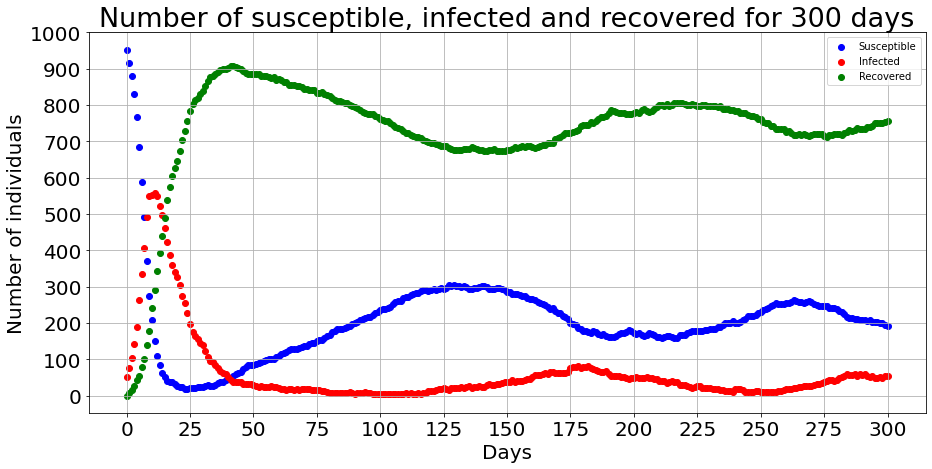

In [21]:
plot1e()

# Problem 1f)

In [14]:
@jit(nopython = True)
def expected_Y(Y0, n = 300, N = 1000, M = 1000):
    """
    Simulates M individuals over n time-steps, N times.
    
    Arguments
    ---------------------------------------
    Y0: numpy-array with length 3
        Initial condition for the simulation of the form Y = [Susceptible, Infected, Recovered] at time 0
    n: int
        Number of time-steps, default 300
    N: int
        Number of time the a population must be simulated, default 1000
    M: int
        number of individuals in the population, default 1000
        
    Returns
    ---------------------------------------
    I_expected.sum(axis = 1)/N: 1xn numpy array
        Average of maximum infected people each day over 1000 simulations
    I: 1x4 numpy array
        Element:
            0: Expected number of maximum number of infected people in a simulation
            1: Variance in the value above
            2: Expected time for maximum infected people [days]
            3: Variance in the value above
    """
    I_expected = np.zeros((n + 1, N), dtype = np.float64)#Maximum number of ingected people each day for every time step
    I_max_value = np.zeros(N, dtype = np.float64)#Maximum number of infected people in a day each simulation
    I_max_expected_time = np.zeros(N, dtype = np.float64)#Time of maximum number of people each simulation

    for i in range(N):
        Y = simulate_Y(Y0, n = n, N = M)[1]#We only need the data over infected people for each time step
        I_expected[:,i] = Y#Store each simulation in a column
        max_index = np.argmax(Y)
        I_max_value[i] = Y[max_index]
        I_max_expected_time[i] = max_index
        
    I = np.array([I_max_value.sum()/N, np.sqrt(np.var(I_max_value)/(N-1)), I_max_expected_time.sum()/N, np.sqrt(np.var(I_max_expected_time)/(N-1))])
    
    return I_expected.sum(axis = 1)/N, I

In [15]:
#Simulates 1000 individuals over 300 days, 1000 times.
start = time()
I_expected, I = expected_Y(Y0)
print("Execution time: ", time() - start)
print("Expected number of maximum infected [people]: ", I[0])
print("Standard deviation of maximum number infected: ", I[1])
print("Expected time of maximum infected [days]: ", I[2])
print("Standard deviation of time of maximum infected: ", I[3])

NameError: name 'Y0' is not defined

In [ ]:
Konf_1 = [I[0]-I[1]*1.960,I[0]+I[1]*1.960]
print(Konf_1)
Konf_2 = [I[2]-I[3]*1.960,I[2]+I[3]*1.960] 
print(Konf_2)

# Problem 1g)

In [ ]:
def simulate_herd_immunity(Y0, n = 300, N = 1000, M = 1000):
    """
    Simulates M individuals over n time-steps, N times, where some of the individuals might be vaccinated.
    
    Arguments
    ---------------------------------------
    Y0: numpy-matrix with dimension 3xL, where L is the number of initial conditions
        Initial condition for the simulation of the form Y = [Susceptible, Infected, Recovered] at time 0
    n: int
        Number of time-steps, default 300
    N: int
        Number of time the a population must be simulated, default 1000
    M: int
        number of individuals in the population, default 1000
        
    Returns
    ---------------------------------------
    Y: 
    expected_time: 1xL numpy array
        Expected time of maximum infected for each initial condition
    expected_max_infected: 1xL numpy array
        Expected number of maximum infected [people] for each initial condition
    """

    m = len((Y0[0]))
    Y = np.zeros((m, n + 1))
    expected_time = np.zeros(m)
    expected_max_infected = np.zeros(m)
    for i in range(m):
        Y[i], expected = expected_Y(Y0[:,i], n = n, N = N, M = M)
        expected_time[i] = expected[2]
        expected_max_infected[i] = expected[0]
    
    return Y, expected_time, expected_max_infected

In [ ]:
#Simulate herd-immunity
#In practice vaccinated people can be removed from the susceptible row,
#but we still use N = 1000 to calculate beta
Y0_1 = np.array([
    [950, 850, 350, 150],
    [50, 50, 50, 50],
    [0, 0 ,0 ,0]
])

start = time()
Y, expected_time, expected_max_infected = simulate_herd_immunity(Y0_1)
print("Execution time: ", time() - start)
print("Expected number of maximum infected [people]: ", expected_max_infected)
print("Expected time of maximum infected [days]: ", expected_time)

In [ ]:
#Plot number of maximum infected individuals over 300 days for each of the initial conditions.
x = np.arange(301)
x_axis = np.arange(0, 301, 25)
y = np.arange(0, 601, 100)
plt.scatter(x, Y[0],marker='o',color='blue')
plt.scatter(x, Y[1],marker='o',color='red')
plt.scatter(x, Y[2],marker='o',color='green')
plt.scatter(x, Y[3],marker='o',color='magenta')
plt.xticks(x_axis, x_axis, size = 20)
plt.yticks(y, y, size = 20)
plt.legend(["0 vaccinated","100 vaccinated","600 vaccinated", "800 vaccinated"])
plotCommands("Days", "Number of individuals", "Number of infected individuals over 300 days")

plt.show()

# Problem 2a)

In [ ]:
#Finding the probability to get more then a 100 for a poisson distribution with expected value at 88.5
Pr = 1
for x in range(101):
    Pr-=88.5**x*np.e**(-88.5)/np.math.factorial(x)
    
print(Pr)
 

In [ ]:
@jit(nopython = True)
def poisson_arrival(l = 1.5, t_max = 59):
    """
    The time it takes for each of the claims to arrive in t_max time interval
    
    Arguments
    ---------------------------------------
    l: float
        lambda-parameter for the poisson-distribution, default 1.5
    t_max: int
        time interval, default 59

    Returns
    ---------------------------------------
    times[:-1]: numpy-array
        Array with all the times the claims arrived. Last element is left out, because it includes a time step greater than t_max.
    """
    time = 0
    times = []

    while(time <= t_max):
        t = random.expovariate(l)#Simulate the time it takes for a poission-event to occur given a parameter lambda
        time += t
        times.append(time)
        
    return times[:-1]

@jit(nopython = True)
def expected_poisson(l = 1.5, t_max = 59, N = 1000, claim_number = 100):
    """
    Simulate a poisson process N times, and check the fraction of the claims greater than claim_number
    
    Arguments
    ---------------------------------------
    l: float
        lambda-parameter for the poisson-distribution, default 1.5
    t_max: int
        time interval, default 59
    N: int
        Number of times to be simulated, default 1000
    claim_number: int
        Number of claims that the probability is computed for
        
    Returns
    ---------------------------------------
    prob/N: float
        The fractions of claims that are greater than claim_number
    """
    prob = 0
    for i in range(N):
        times = poisson_arrival(l = l, t_max = t_max)
        if len(times) > claim_number:
            prob += 1

    return prob/N

In [ ]:
start = time()
ex = expected_poisson()
print("Execution time: ", time() - start)
print("Probability of total claims to exceed 100: ", ex)

In [ ]:
#Plot the cumulative sum of the poisson process of the number of claims in 59 days (10 realizations)
realizations1 = 10
x_1 = np.arange(0, 61, 10)
y = np.arange(0, 101, 10)
cmap = ["magenta", "red", "blue", "green", "black", "orange", "darksalmon", "crimson", "cyan", "darkorchid"]

for i in range(realizations1):
    times = poisson_arrival()
    for j in range(len(times)-1):
        plt.hlines(j, times[j], times[j+1], colors = [cmap[i]])

plt.xticks(x_1, x_1, size = 20)
plt.yticks(y, y, size = 20)
plotCommands("Day", "Number of claims", r"10 realizations of $X(t), 0 \leq t \leq 59$")
plt.show()

# Problem 2b)

In [ ]:
@jit(nopython = True)
def single_amount_simulation(gamma = 10):
    """
    A single exponential-distribution with parameter gamma.
    
    Arguments
    ---------------------------------------
    gamma: float
        Parameter for exponential distribution, default 10
        
    Returns
    ---------------------------------------
    times: numpy-array
        The times at which each claim arrived
    dist: numpy-array
        The exponential distribution of the claim amount for len(times) claims.
    """
    times = poisson_arrival()
    dist = np.random.exponential(scale = 1/gamma, size = len(times))
    return times, dist

def expected_amount(gamma = 10, N = 1000, min_amount = 8):
    """
    Calculate the probability of claims amounting to a value greater than min_amount (millions), after N simulations
    
    Arguments
    ---------------------------------------
    gamma: float
        Parameter for exponential distribution, default 10
    N: int
        Number of times to be simulated, default 1000
    min_amount: float
        The amount the probability is to be calculated
        
    Returns
    ---------------------------------------
    prob/N: float
        probability of claims amounting to a value greater than min_amount (millions)
    """
    prob = 0
    for i in range(N):
        times, dist = single_amount_simulation(gamma = gamma)#Simulate number of claims each time, before simulating the total amount
        if dist.sum() > min_amount:
            prob += 1
    return prob/N


In [ ]:
start = time()
prob = expected_amount()
print("Execution time: ", time() - start)
print("Probability of total claim amount to exceed 8 million kroner: ", prob)

In [ ]:
#Plot the cumulative sum of the claim amount in 59 days (10 realizations)
realizations2 = 10
x_1 = np.arange(0, 61, 10)
y = np.arange(1, 11)
cmap = ["magenta", "red", "blue", "green", "black", "orange", "darksalmon", "crimson", "cyan", "darkorchid"]

for i in range(realizations2):
    times, dist = single_amount_simulation()
    dist = dist.cumsum()
    for j in range(len(times)-1):
        plt.hlines(dist[j], times[j], times[j+1], colors = [cmap[i]])
    
plt.xticks(x_1, x_1, size = 20)
plt.yticks(y, y, size = 20)
plotCommands("Day", "Claim amount in million [kroner]", r"10 realizations of $Z(t), 0 \leq t \leq 59$")
plt.show()